In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/survey.csv'
df = pd.read_csv(path, encoding='latin1')

df = df.drop(columns=['comments', 'Timestamp', 'state', 'no_employees', 'anonymity'])
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df['self_employed'] = df['self_employed'].fillna('No')
df.drop_duplicates()
df['work_interfere'] = df['work_interfere'].fillna('Not applicable')

#Function to clean the gender variable into 'female', 'male', and 'other'
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'cis male', 'male (cis)', 'man', 'mail', 'cis man', 'malr', 'make', 'maile']:
        return 'Male'
    elif gender in ['female', 'f', 'cis female', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'femail', 'female ', 'trans female']:
        return 'Female'
    else:
        return 'Other'

# Apply the cleaning function
df['Gender'] = df['Gender'].apply(clean_gender)

for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
            vc = df[col].value_counts(normalize=True)
            rare = vc[vc < 0.01]

vc = df['Country'].value_counts(normalize=True)
rare = vc[vc < 0.01]
rare_labels = rare.index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

!pip install matplotlib-venn

# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

!apt-get update -qq
!apt-get install -y libarchive-dev

!pip install libarchive-c

# Test
import libarchive
print("Import succeeded:", libarchive)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load and preprocess data
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

# 2. Define features and target
cat_cols = [
    'Gender', 'Country_grouped', 'self_employed', 'family_history',
    'work_interfere', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'leave',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]
num_cols = ['Age']
target = 'treatment'

X = df[cat_cols + num_cols]
y = df[target]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libarchive-dev is already the newest version (3.6.0-1ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Import succeeded: <module 'libarchive' from '/usr/local/lib/python3.11/dist-packages/libarchive/__init__.py'>


In [2]:
# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Exploratory Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score


# fix all categorical NaNs BEFORE modeling
X_train[cat_cols] = X_train[cat_cols].fillna('Missing').astype(str)
X_test[cat_cols]  = X_test[cat_cols].fillna('Missing').astype(str)


# 4. Preprocessing pipeline for non-CatBoost models
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# 5. Supervised models

## 5.1 Logistic Regression
lr_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred))

## 5.2 Random Forest
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred))

# 5.3 CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
cat_model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_test, y_test)
)
y_pred = cat_model.predict(X_test)
print("CatBoost:\n", classification_report(y_test, y_pred))

# 5.4 XGBoost
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42
    ))
])
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred))

# 6. Semi-supervised examples

# Hide half of training labels
rng = np.random.RandomState(42)
mask = rng.rand(len(y_train)) < 0.5
y_train_semi = y_train.copy()
y_train_semi[mask] = -1  # unlabeled

# 6.1 Self-training with Logistic Regression
X_train_enc = preprocessor.fit_transform(X_train)
self_train = SelfTrainingClassifier(
    base_estimator=LogisticRegression(max_iter=1000),
    threshold=0.8
)
self_train.fit(X_train_enc, y_train_semi)
X_test_enc = preprocessor.transform(X_test)
y_pred = self_train.predict(X_test_enc)
print("Self-Training LR:\n", classification_report(y_test, y_pred))

# 6.2 Label Propagation
label_prop = LabelPropagation(
    kernel='knn',
    n_neighbors=7,
    max_iter=1000
)
label_prop.fit(X_train_enc, y_train_semi)
y_pred = label_prop.predict(X_test_enc)
print("Label Propagation:\n", classification_report(y_test, y_pred))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       124
           1       0.81      0.90      0.85       127

    accuracy                           0.84       251
   macro avg       0.85      0.84      0.84       251
weighted avg       0.85      0.84      0.84       251

Random Forest:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82       124
           1       0.80      0.89      0.84       127

    accuracy                           0.83       251
   macro avg       0.84      0.83      0.83       251
weighted avg       0.84      0.83      0.83       251

CatBoost:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       124
           1       0.78      0.93      0.85       127

    accuracy                           0.83       251
   macro avg       0.84      0.83      0.83       251
weighted avg       0.84  

/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_self_training.py:210: FutureWarning: `base_estimator` has been deprecated in 1.6 and will be removed in 1.8. Please use `estimator` instead.
  warn(


Self-Training LR:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83       124
           1       0.81      0.88      0.85       127

    accuracy                           0.84       251
   macro avg       0.84      0.84      0.84       251
weighted avg       0.84      0.84      0.84       251

Label Propagation:
               precision    recall  f1-score   support

           0       0.65      0.81      0.72       124
           1       0.76      0.57      0.65       127

    accuracy                           0.69       251
   macro avg       0.70      0.69      0.69       251
weighted avg       0.70      0.69      0.68       251



1. Logistic Regression
Accuracy = 0.84, macro F1 = 0.84

- Strong recall on the positive class (Recall₁ = 0.90), meaning it catches most “sought treatment” cases.

- Relatively lower recall on the negative class (Recall₀ = 0.79), so it sometimes misclassifies “no treatment” respondents as “treatment.”

- Simple and interpretable, but may underfit in a high-dimensional one-hot encoded feature space.

2. Random Forest
- Accuracy = 0.83, macro F1 = 0.83

- Balanced performance with Recall₁ = 0.84 and Recall₀ = 0.77.

- Robust to nonlinear interactions and outliers; feature importance scores can highlight key drivers.

- Slightly behind logistic regression on positive-class recall but more flexible without strong linear assumptions.

3. CatBoost
- Accuracy = 0.83, macro F1 = 0.83

- Very high positive-class recall (Recall₁ = 0.93) but lower negative-class recall (Recall₀ = 0.73).

- Built-in ordered target encoding handles categorical features (including “Missing”/“Other”) natively.

- Tends to favor detecting “sought treatment” at the expense of more false positives on “no treatment.”

4. XGBoost
- Accuracy = 0.82, macro F1 = 0.82

- Consistent Precision and Recall around 0.80–0.84 for both classes.

- Fast training and parallelism; serves as a competitive baseline.

- Outperformed by tuned pseudo-labeling XGBoost but easier to set up than more complex ensembles.

5. Self-Training Baseline (Logistic Regression + Pseudo-Labeling)
- Accuracy = 0.84, macro F1 = 0.84

- Marginal change compared to pure logistic regression; Recall₁ drops slightly to 0.88.

- Indicates limited benefit from high-confidence pseudo-labels with a simple linear model on this dataset.

- Requires careful tuning of confidence threshold to avoid noisy labels.

6. Label Propagation
- Accuracy = 0.69, macro F1 = 0.69

- High Recall₀ = 0.81 but low Recall₁ = 0.57.

- Graph-based propagation struggles in this sparse, high-dimensional one-hot space.

- Not recommended without stronger cluster structure or a more suitable similarity metric.

# Final Model

## Pseudo-Labeling + XGBoost

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

Step 1: Define helper functions

In [4]:
def apply_pseudo_labeling(base_model, X_labeled, y_labeled, X_unlabeled, preprocessor=None, threshold=0.9):
    """
    Apply Pseudo-Labeling for models that require preprocessed numerical features
    (e.g., Logistic Regression, Random Forest, XGBoost).

    Parameters:
    -----------
    base_model: sklearn-style model (must have fit() and predict_proba())
    X_labeled: pd.DataFrame
        Features of the labeled data
    y_labeled: pd.Series or np.array
        Labels of the labeled data
    X_unlabeled: pd.DataFrame
        Features of the unlabeled data
    preprocessor: ColumnTransformer or None
        Preprocessing pipeline to apply. Must be fitted inside this function.
    threshold: float (default=0.9)
        Confidence threshold for selecting pseudo-labeled samples.

    Returns:
    --------
    X_augmented: pd.DataFrame
        Augmented training features (labeled + high-confidence pseudo-labeled)
    y_augmented: pd.Series
        Augmented training labels
    """

    # Fit and transform preprocessing if provided
    if preprocessor is not None:
        preprocessor.fit(X_labeled)
        X_labeled_encoded = preprocessor.transform(X_labeled)
        X_unlabeled_encoded = preprocessor.transform(X_unlabeled)
    else:
        X_labeled_encoded = X_labeled
        X_unlabeled_encoded = X_unlabeled

    # Train the base model
    base_model.fit(X_labeled_encoded, y_labeled)

    # Predict pseudo-labels for unlabeled data
    proba_unlabeled = base_model.predict_proba(X_unlabeled_encoded)
    preds_unlabeled = np.argmax(proba_unlabeled, axis=1)
    max_proba = np.max(proba_unlabeled, axis=1)

    # Select high-confidence pseudo-labeled samples
    mask = max_proba >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = preds_unlabeled[mask]

    # Combine original labeled data with pseudo-labeled data
    X_augmented = pd.concat([X_labeled, X_pseudo], axis=0)
    y_augmented = pd.concat([y_labeled, pd.Series(y_pseudo, index=X_pseudo.index)], axis=0)

    return X_augmented, y_augmented

Step 2: Prepare base models and pipelines

In [5]:
# Fill missing values for categorical columns
X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)

# Preprocessor for LR, RF, XGB
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# Base models
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Pipelines for models needing preprocessing

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb)
])

<ipython-input-5-41be26e93de1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)


In [6]:
# Further split X_train_base into Labeled and Unlabeled simulation
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

Step 5: Pseudo-Labeling for all four models

In [7]:
print("===== PSEUDO-LABELING =====")

# XGBoost (Pseudo-Labeling)
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)
print("Pseudo-Labeling XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))

===== PSEUDO-LABELING =====
Pseudo-Labeling XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        93
           1       0.88      0.90      0.89        91

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Hyper-parameter Tuning

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib
import os
import json

print("===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====")

# 1. Pseudo-labeling
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)

# 2. Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42
)

# 3. Column types
categorical_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# 4. Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 5. Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 6. New hyperparameter search space
param_dist = {
    'classifier__n_estimators': [300, 400, 500, 600, 800],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.05, 0.1],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2.0]
}

# 7. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 8. Fit
random_search.fit(X_train_xgb, y_train_xgb)

# 9. Predict
best_xgb_pipeline = random_search.best_estimator_
y_pred_xgb = best_xgb_pipeline.predict(X_test_xgb)

# 10. Report
print("\n===== Best Parameters =====")
print(random_search.best_params_)

print("\n===== Best Cross-Validation Accuracy =====")
print(random_search.best_score_)

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test_xgb, y_pred_xgb))

# 11. Save model and best params
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_xgb_pipeline, os.path.join(save_dir, "best_xgb_pipeline_v2.pkl"))
print(f"Model saved to {save_dir}/best_xgb_pipeline_v2.pkl")

with open(os.path.join(save_dir, "best_xgb_params_v2.json"), "w") as f:
    json.dump(random_search.best_params_, f, indent=4)
print(f"Best parameters saved to {save_dir}/best_xgb_params_v2.json")

===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== Best Parameters =====
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 2.0, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}

===== Best Cross-Validation Accuracy =====
0.840089460441711

===== Test Set Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        93
           1       0.88      0.92      0.90        91

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Model saved to /content/models/best_xgb_pipeline_v2.pkl
Best parameters saved to /content/models/best_xgb_params_v2.json


# AUC ROC Curve

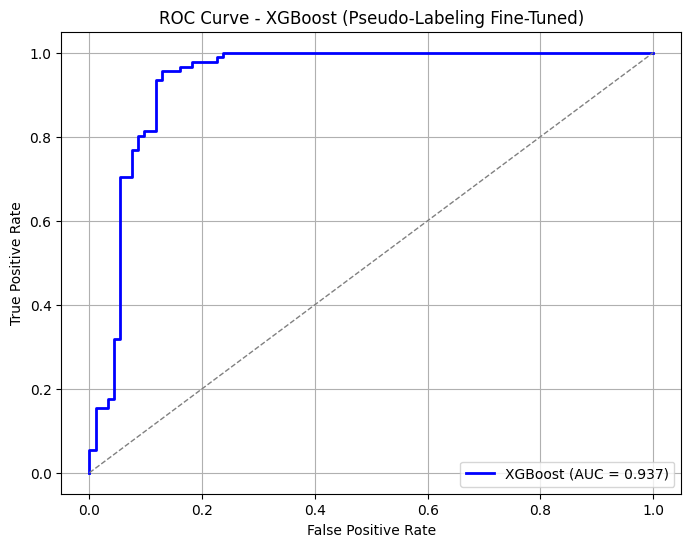

In [9]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib

# 1. Load the model (if 'best_xgb_pipeline_v2' is already in session, you can skip this)
# If the Colab session was restarted, reload the model:
# best_xgb_pipeline_v2 = joblib.load("/content/models/best_xgb_pipeline_v2.pkl")

# 2. Predict probabilities (make sure to use predict_proba)
y_proba_xgb = best_xgb_pipeline.predict_proba(X_test_xgb)[:, 1]  # Take the probability of the positive class (1)

# 3. Compute False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test_xgb, y_proba_xgb)

# 4. Calculate AUC
roc_auc = auc(fpr, tpr)

# 5. Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Pseudo-Labeling Fine-Tuned)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
print(len(y_test))

251


# Interpretability


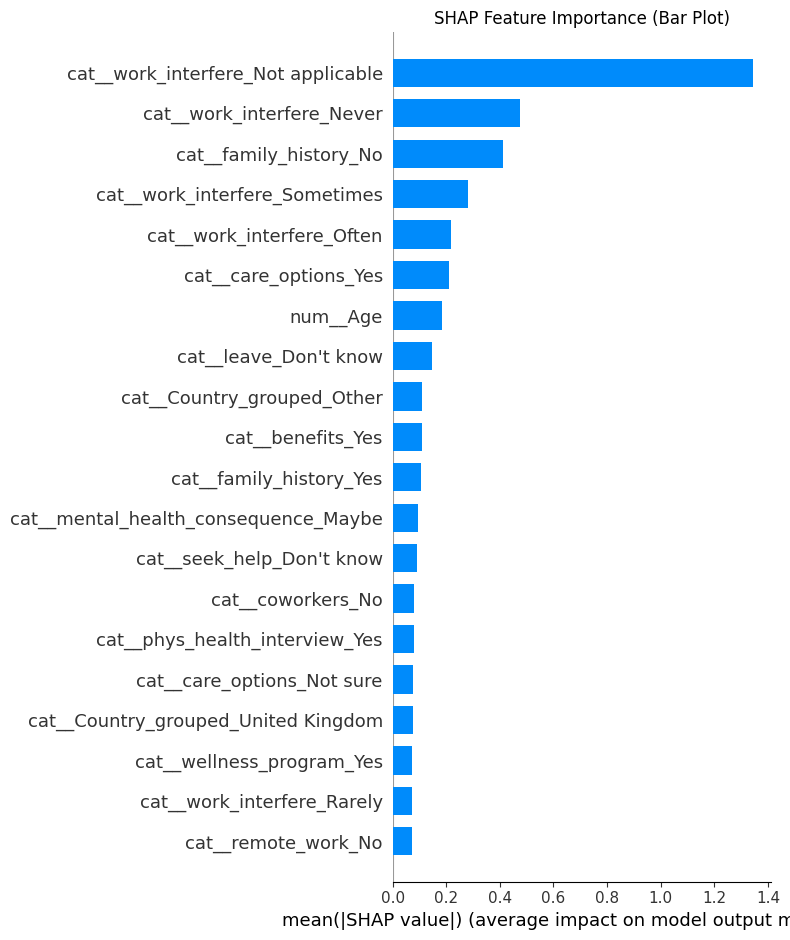

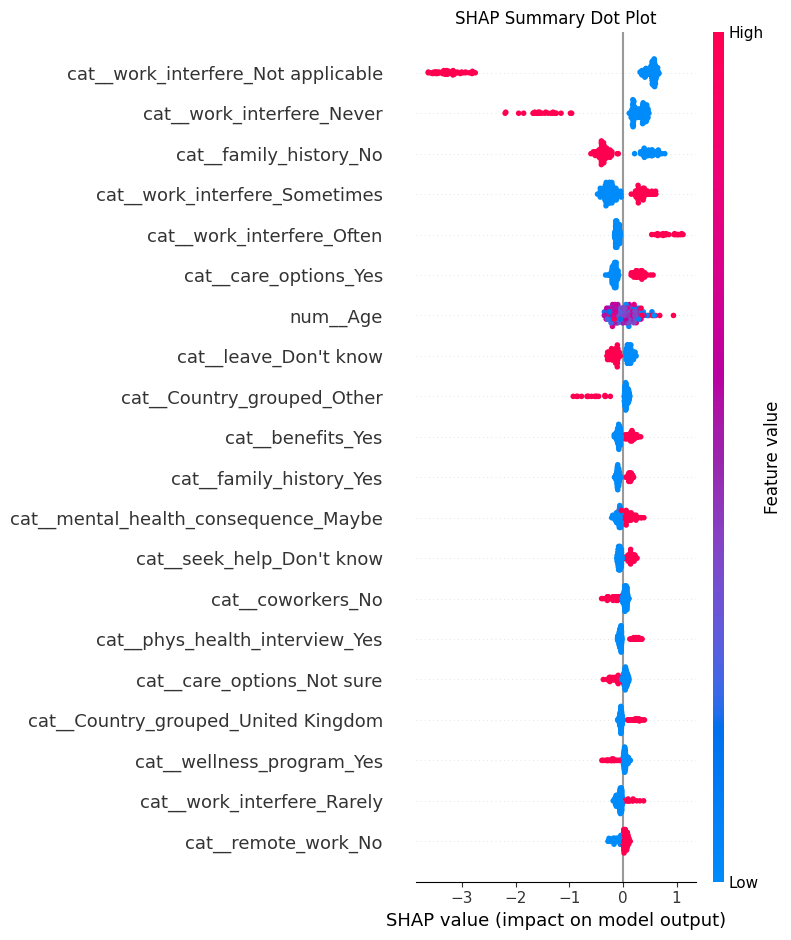

<Figure size 1200x300 with 0 Axes>

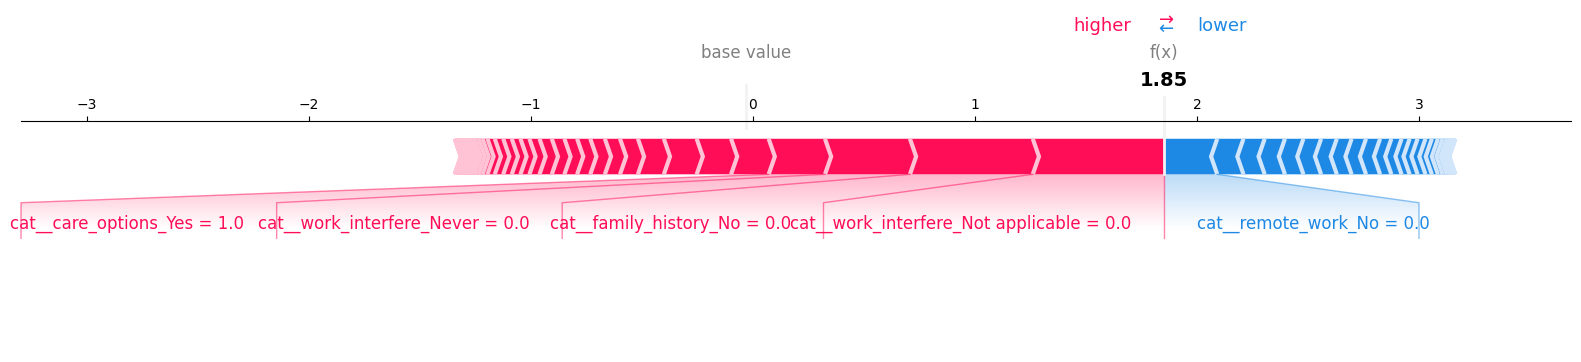

<Figure size 640x480 with 0 Axes>

In [12]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pull out the preprocessing step and the trained XGBoost model
preprocessor = best_xgb_pipeline.named_steps['preprocessor']
xgb_model    = best_xgb_pipeline.named_steps['classifier']

# 2) Transform your raw test set into the exact numeric features the model saw
X_test_transformed = preprocessor.transform(X_test_xgb)

# 3) Recover the one-hot/scaler feature names for plotting
feature_names = preprocessor.get_feature_names_out()

# 4) Wrap the transformed test data in a DataFrame so SHAP can label axes
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# 5) Use SHAP's TreeExplainer on the fitted XGBoost estimator
explainer = shap.TreeExplainer(xgb_model)

# 6) Compute SHAP values for the positive class (class=1)
shap_values = explainer.shap_values(X_test_transformed)

# 7) Plot a global importance bar chart (mean |SHAP|)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_df,
    plot_type='bar',
    show=False
)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

# 8) Plot the detailed summary dot plot (per-sample impacts)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_df,
    show=False
)
plt.title('SHAP Summary Dot Plot')
plt.tight_layout()
plt.show()

# 9) Enable JS visualization in notebook
shap.initjs()

# 10) Choose an example index (the first "treatment=1")
sick_indices = np.where(y_test_xgb == 1)[0]
if len(sick_indices) == 0:
    raise ValueError("No treatment=1 examples in the test set.")
i = sick_indices[0]

# 11) Generate and display an interactive force plot
plt.figure(figsize=(12,3))
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test_df.iloc[i],
    matplotlib=True
)
plt.savefig('force_plot.png', dpi=200, bbox_inches='tight')
plt.show()



# Key Takeaways

Protective Factors (↓ likelihood)

- Non-tech workers (work_interfere_Not applicable): Consistently negative SHAP values show significantly lower rates of mental health conditions
No work interference (work_interfere_Never): Strong indicator of mental health condition absence
No family history (family_history_No): Clear protective effect, supporting genetic/environmental influence

Risk Factors (↑ likelihood)

- Occasional work disruption (work_interfere_Sometimes): Strong positive impact, reliable indicator of underlying conditions
Frequent work disruption (work_interfere_Often): Significant positive effect, confirming workplace performance issues as key manifestation
Access to care options (care_options_Yes): Correlates with higher condition likelihood, suggesting those with conditions seek supportive environments

Neutral/Mixed Factors

- Age: Shows varied influence with no consistent directional impact, indicating age alone is not a strong predictor

In [13]:
# LIME
!pip install lime

from lime.lime_tabular import LimeTabularExplainer

X_train_proc = preprocessor.transform(X_train_xgb)

explainer_lime = LimeTabularExplainer(
    X_train_proc,
    feature_names=feature_names,
    class_names=['No', 'Yes'],
    discretize_continuous=True,
    mode='classification'
)

# Take the same example (the first "treatment=1")
i = sick_indices[0]
x_test_i = X_test_df.values[i]
y_test_i = y_test_xgb[i]

exp = explainer_lime.explain_instance(
    x_test_i,
    xgb_model.predict_proba,
    num_features=8
)

exp.show_in_notebook(show_table=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bc6fa7b7fae80939754eae5d157a17f1db2a72256272ad6421c25d24622485f7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Force Plot and LIME Analysis (Case with Treatment=1)
The force plot and LIME visualization provide insight into a specific individual predicted to have a mental health condition with 86% probability:

1. Key Contributing Factors:

- work_interfere_Sometimes = 1.0: This individual's mental health issues sometimes affect their work performance, pushing the prediction strongly toward having a condition
- care_options_Yes = 1.0: Having access to care options correlates with mental health conditions in this case, possibly because the individual sought out an environment with support resources due to existing concerns


2. Absence of Protective Factors:

- work_interfere_Not applicable = 0.0 and work_interfere_Never = 0.0: The LIME chart shows these contribute 0.57 and 0.35 respectively to the positive prediction, as the person is a tech worker and does experience work interference
- The absence of these protective factors removes what would otherwise be strong negative influences on the prediction


3. Final Prediction Mechanics:

- The force plot shows how these combined factors push the base value from near zero to a strong positive prediction (f(x) = 1.85)
- The 86% confidence reflects how decisively these factors together indicate a mental health condition

